In [1]:
import Pkg
Pkg.activate(pwd())

using HTTP
using Gumbo
using AbstractTrees
using Dates
using DataFrames
using MySQL

using VegaLite
using DataVoyager
using Interact

using TextAnalysis
using JSON

using DotEnv

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-2937365082547727896\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9007729547572463401\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-2937365082547727896\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [15]:
DotEnv.config()
opts = Dict(MySQL.API.MYSQL_ENABLE_CLEARTEXT_PLUGIN => 1)
user = ENV["mysql_user"]
pass = ENV["mysql_password"]
conn = MySQL.connect("pdspracticemydbcit.services.brown.edu", user,pass, db = "ccvpubs", opts=opts)

MySQL Connection
------------
Host: pdspracticemydbcit.services.brown.edu
Port: 3306
User: ccvpubs_api
DB:   ccvpubs


In [16]:
data = MySQL.query(conn, """SELECT * FROM pubsNew;""", DataFrame)
small_data = DataFrame( year = parse.(Int, data[!, :year]), month = data[!, :month])

rows = eachrow(small_data)

for row in rows
    if row.month[1] == '0'
        row.month = string(row.month[2])
    end
    if row.month != "Missing"
        row.month = string(Dates.monthname(parse(Int,row.month[1])))
    else
        row.month = "Missing"
    end
end

small_data

┌ Warning: `MySQL.query(conn, sql, DataFrame)` is deprecated; use `MySQL.query(conn, sql) |> DataFrame(args...)` instead
│   caller = ip:0x0
└ @ Core :-1


,year,month
,Int64,String⍰
1,2017,September
2,2017,September
3,2017,September
4,2017,September
5,2018,May
6,2018,May
7,2017,Missing
8,2017,April
9,2017,April


In [17]:
small_data |> Voyager();

In [4]:
small_data_json = JSON.json(small_data)
spec = """{
  "autosize": "pad",
  "padding": 5,
  "height": 200,
  "title": {"text": "Number of Publications vs Year", "frame": "group"},
  "style": "cell",
  "data": {
    "name": "source",
    "values": $(small_data_json)
  },
    "selection": {
    "highlight": {"type": "single", "empty": "none", "on": "mouseover"},
    "select": {"type": "multi"}
  },

    "signals": [
        {"name": "x_step", "value": 20},
        {
          "name": "width",
          "update": "bandspace(domain('x').length, 0.1, 0.05) * x_step"
        },
        {
          "name": "select",
          "value": false,
          "on": [
            {"events": "click", "update": "datum"},
            {"events": "dblclick", "update": "null"}
          ]
        }
      ],
    "marks": [
    {
      "name": "marks",
      "type": "rect",
      "style": ["bar"],
      "from": {"data": "data_0"},
      "encode": {
        "update": {
          "fill": {"value": "#00FFFF"},
          "stroke": {"value": "black"},
          "cursor": {"value": "pointer"},
          "tooltip": {
            "signal": "{\"year\": ''+datum[\"year\"], \"Count of Records\": format(datum[\"__count\"], \"\")}"
          },
          "x": {"scale": "x", "field": "year"},
          "width": {"scale": "x", "band": true},
          "y": {"scale": "y", "field": "__count"},
          "y2": {"scale": "y", "value": 0}
        }
      }
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "band",
      "domain": {"data": "data_0", "field": "year", "sort": true},
      "range": {"step": {"signal": "x_step"}},
      "paddingInner": 0.1,
      "paddingOuter": 0.05
    },
    {
      "name": "y",
      "type": "linear",
      "domain": {"data": "data_0", "field": "__count"},
      "range": [{"signal": "height"}, 0],
      "nice": true,
      "zero": true
    }
  ],
  "axes": [
    {
      "scale": "x",
      "orient": "bottom",
      "grid": false,
      "title": "Year",
      "labelAlign": "right",
      "labelAngle": 270,
      "labelBaseline": "middle",
      "zindex": 1
    },
    {
      "scale": "y",
      "orient": "left",
      "grid": false,
      "title": "Count of Records",
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "zindex": 1
    },
    {
      "scale": "y",
      "orient": "left",
      "gridScale": "x",
      "grid": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "domain": false,
      "labels": false,
      "maxExtent": 0,
      "minExtent": 0,
      "ticks": false,
      "zindex": 0
    }
  ]"""
VegaLite.VGSpec(JSON.parse(spec))

ErrorException: Expected ',' here
Line: 42
Around: ...nal": "{"year": ''+datum["year...
                    ^


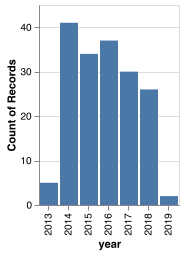

In [12]:
vl"""{
  "data": {
    "name": "source"
  },
  "mark": "bar",
  "encoding": {
    "x": {
      "field": "year",
      "type": "nominal"
    },
    "y": {
      "aggregate": "count",
      "field": "*",
      "type": "quantitative"
    }
  },
  "config": {
    "overlay": {
      "line": true
    },
    "scale": {
      "useUnaggregatedDomain": true
    }
  }
}"""(small_data)


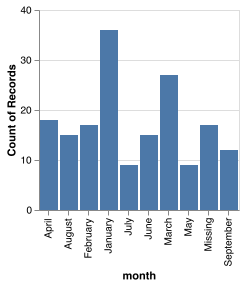

In [25]:
vl"""{
  "data": {
    "name": "source"
  },
  "mark": "bar",
  "encoding": {
    "x": {
      "field": "month",
      "type": "nominal"
    },
    "y": {
      "aggregate": "count",
      "field": "*",
      "type": "quantitative"
    }
  },
  "config": {
    "overlay": {
      "line": true
    },
    "scale": {
      "useUnaggregatedDomain": true
    }
  }
}"""(small_data)

In [4]:
# create the corpus
sds = []
rows = eachrow(data)
for x in rows
    if x.abstract != "Missing"
        push!(sds, StringDocument(x.abstract))
    else
        push!(sds, StringDocument(x.title))
    end
end

# sds = map(x -> StringDocument(x.abstract), eachrow(data))
corpus = Corpus(sds)

# clean up the data
sds = map(x->remove_corrupt_utf8!(x), sds)
prepare!(corpus, strip_articles| strip_non_letters| strip_stopwords| strip_pronouns|strip_html_tags)
remove_case!(corpus)
remove_words!(corpus, ["\n", "a"])

# set up the lexicon
lexicon(corpus)
update_lexicon!(corpus)


# light stemming - combine simple 's' plurals with their singular (e.g. models == model)
pairs = Pair{String, String}[]
for (k, v) in lexicon(corpus)
    if k[end] == 's' && haskey(lexicon(corpus), k[1:end-1])
        push!(pairs, k => k[1:end-1])
    end
end

#remove words that were not stripped with one letter
for (w, f) in lexicon(corpus)
    if length(w) == 1
        delete!(lexicon(corpus),w)
    end
end
update_lexicon!(corpus)

# replace plurals and update the lexicon
for doc in corpus
    for pair in pairs
        doc.text = replace(doc.text, pair)
    end
end
update_lexicon!(corpus)

# set up inverse index
inverse_index(corpus)
update_inverse_index!(corpus)



In [18]:
m =  DocumentTermMatrix(corpus)
tfidf = tf_idf(m)

175×2178 SparseArrays.SparseMatrixCSC{Float64,Int64} with 4153 stored entries:
  [30  ,    1]  =  0.406513
  [48  ,    1]  =  0.0271008
  [169 ,    2]  =  0.0326885
  [88  ,    3]  =  1.2912
  [22  ,    4]  =  0.0202297
  [83  ,    4]  =  0.0262334
  [123 ,    4]  =  0.0347536
  [19  ,    5]  =  0.508272
  [138 ,    5]  =  0.451797
  [145 ,    5]  =  0.451797
  [169 ,    6]  =  0.065377
  [39  ,    7]  =  0.040285
  ⋮
  [15  , 2172]  =  0.0487034
  [27  , 2172]  =  0.0395039
  [39  , 2172]  =  0.0320302
  [103 , 2172]  =  0.296279
  [172 , 2172]  =  0.0587661
  [13  , 2173]  =  0.322799
  [7   , 2174]  =  0.638806
  [18  , 2174]  =  0.558955
  [83  , 2175]  =  0.0999636
  [83  , 2176]  =  0.0333212
  [138 , 2177]  =  0.573865
  [46  , 2178]  =  0.573865

In [5]:
# bi-grams - find common two word phrases

bg = NGramDocument[]

for d in corpus
    push!(bg, NGramDocument(ngrams(d, 2), 1, d.metadata))
end

bg_corpus = Corpus(bg)

# set up inverse index
inverse_index(bg_corpus)
update_inverse_index!(bg_corpus)

# set up the lexicon
lexicon(bg_corpus)
update_lexicon!(bg_corpus)

In [6]:
# tri-grams - find common three word phrases

tg = NGramDocument[]

for d in corpus
    push!(tg, NGramDocument(ngrams(d, 3), 1, d.metadata))
end

tg_corpus = Corpus(tg)

# set up inverse index
inverse_index(tg_corpus)
update_inverse_index!(tg_corpus)

# set up the lexicon
lexicon(tg_corpus)
update_lexicon!(tg_corpus)

In [7]:
# get overall count of a term in the n+1 gram's dictionary
function subgram_count(term, np1grams)
    count = 0
    for (k, v) in np1grams
        if occursin(term, k)
            count += v
        end
    end
    
    return count
end

subgram_count (generic function with 1 method)

In [8]:

# prune and combine an n gram with it's n+1 gram given a cut off count
function remove_ngrams(ngrams, np1grams, cut_off)
    new_ngrams = Dict{String, Int}()
    for (k, v) in ngrams
        new_count = v - subgram_count(k, np1grams)
        if new_count > cut_off
            new_ngrams[k] = new_count
        end
    end
    
    return merge(new_ngrams, np1grams)
end

remove_ngrams (generic function with 1 method)

In [9]:
function remove_ngrams(ngrams, cut_off)
    new_ngrams = Dict{String, Int}()
    for (k, v) in ngrams
        if v > cut_off
            new_ngrams[k] = v
        end
    end
    
    return new_ngrams
end

remove_ngrams (generic function with 2 methods)

In [10]:
# combine ngrams and find most common words and phrases
tg_cut_off = 2
bg_cut_off = 4
ug_cut_off = 15

pubs_cut_off = 3

new_tg = remove_ngrams(lexicon(tg_corpus), tg_cut_off)
new_bg = remove_ngrams(lexicon(bg_corpus), new_tg, bg_cut_off)
new_ug = remove_ngrams(lexicon(corpus), new_bg, ug_cut_off)


# turn the n-grams into tabular data for plotting
word_data = NamedTuple{(:abstract, :freq, :pubs), Tuple{String, Int, Array}}[]
for (word, count) in new_ug
    inds = []
    word_len = length(split(word))
    if word_len == 3
        inds = inverse_index(tg_corpus)[word]
    elseif word_len == 2
        inds = inverse_index(bg_corpus)[word]
    else
        inds = inverse_index(corpus)[word]
    end

    freq = 0
    total = 0
    for index in inds
        allWords = tokens(corpus[index])
        total = size(allWords)[1] + total
    end
    freq = (count/total)*1000
    freq = floor(freq)
        
        
    push!(word_data, NamedTuple{(:abstract, :freq, :pubs), Tuple{String, Int, Array}}((word, freq, inds)))

#     push!(word_data, NamedTuple{(:abstract, :count, :pubs), Tuple{String, Int, Array}}((word, count * word_len^2, inds)))
 
end

word_data |> DataFrame |> describe

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,Type
1,abstract,,ability,,zinc,674,,String
2,freq,23.8412,5,16.0,176,,,Int64
3,pubs,,"[1, 2, 4, 128]",,[175],527,,Array


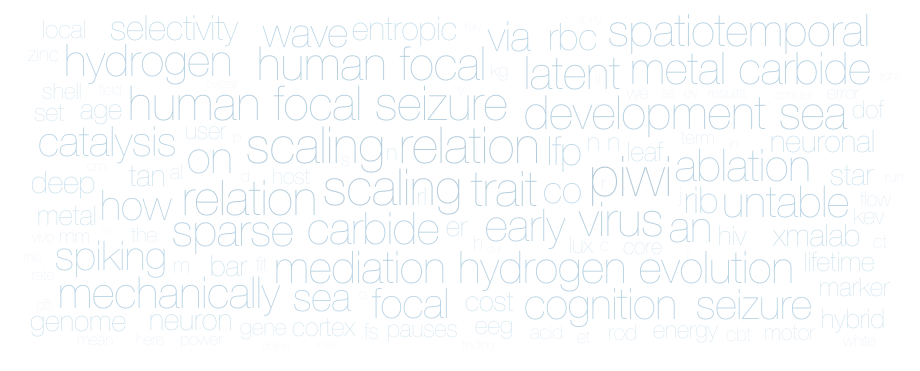

In [11]:

word_data_json = JSON.json(word_data);

word_cloud_spec = """{
  "width": 900,
  "height": 350,
  "padding": 10,
  "signals": [
    {"name": "hoverID", "value": 0}
  ],

  "data": [
    {
      "name": "table",
      "values": $(word_data_json)
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "log",
      "domain": {"data": "table", "field": "freq"},
      "range": {"scheme": "purpleblue"}
    }
  ],

  "marks": [
    {
      "type": "text",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "text": {"field": "abstract"},
          "align": {"value": "center"},
          "baseline": {"value": "alphabetic"},
          "fill": {"scale": "color", "field": "freq"}
        },
        "update": {
          "fillOpacity": [
            {"test": "indexof(datum.pubs, hoverID) > 0", "value": 1.0},
            {"value": 0.3}
          ]
        },
        "hover": {
          "fillOpacity": {"value": 1.0}
        }
      },
      "transform": [
        {
          "type": "wordcloud",
          "size": [{"signal": "width"}, {"signal": "height"}],
          "text": {"field": "text"},
          "font": "Helvetica Neue, Arial",
          "fontSize": {"field": "datum.freq"},
          "fontSizeRange": [12, 56],
          "padding": 2
        }
      ]
    }
  ]
}"""

VegaLite.VGSpec(JSON.parse(word_cloud_spec))